In [3]:
import numpy as np
import pandas as pd
import polars as pl
import pickle
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw

from src.setup.setup_data import setup_train_x_data, setup_train_y_data, sample_data
from src.typing.xdata import XData, DataRetrieval

In [4]:
DATA_PATH = Path('data/')
SHRUNKEN_PATH = DATA_PATH / 'shrunken/'

# check if global variables are defined
if '_x_data' not in globals():
    _x_data = None

if '_y_data' not in globals():
    _y_data = None

if '_train_data' not in globals():
    _train_data = None

In [5]:
def get_x_data() -> XData:
    global _x_data

    if _x_data is not None:
        return _x_data
    
    print('Loading x_data from disk...')
    _x_data = setup_train_x_data(SHRUNKEN_PATH, get_train_data())

    return _x_data

def get_y_data():
    global _y_data

    if _y_data is not None:
        return _y_data

    print('Loading y_data from disk...')
    _y_data = setup_train_y_data(get_train_data())

    return _y_data

def get_train_data(sample_size: int = -1, sample_split: float = 0.5):
    global _train_data

    if _train_data is not None:
        return _train_data

    print('Loading train_data from disk...')
    _train_data = pl.read_parquet(SHRUNKEN_PATH / "train.parquet")
    _train_data = _train_data.to_pandas(use_pyarrow_extension_array=True)

    if sample_size > 0:
        _train_data = sample_data(_train_data, sample_size, sample_split)

    return _train_data

def get_test_data():
    print('Loading test_data from disk...')
    return pl.read_parquet(SHRUNKEN_PATH / "test.parquet")

def visualize_molecule(molecule, desc = ""):
    print(desc)
    if isinstance(molecule, str):
        molecule = Chem.MolFromSmiles(molecule)
    molecule_image = Draw.MolToImage(molecule, size=(300, 300))
    display(molecule_image)

## Building block 1 structure removal

In [6]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rgd
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

In [7]:
train_data = get_train_data(100_000, 0.5)
x = get_x_data()
x.retrieval = DataRetrieval.SMILES

Loading train_data from disk...
Loading x_data from disk...


In [8]:
def remove_specific_substructure(molecule_smiles, substructure_smarts):
    mol = Chem.MolFromSmiles(molecule_smiles)
    substructure = Chem.MolFromSmarts(substructure_smarts)

    # Find all matches of the substructure
    matches = mol.GetSubstructMatches(substructure)
    if not matches:
        return Chem.MolToSmiles(mol)  # Return original if no substructure found

    # Sort matches to find the specific one if needed, otherwise just remove all found
    for match in matches:
        # Create editable molecule
        emol = Chem.EditableMol(mol)

        # Delete atoms by reversed index order to not mess up remaining indices
        for idx in sorted(match, reverse=True):
            emol.RemoveAtom(idx)

        # Get the modified molecule
        mol = emol.GetMol()
    
    # Check if the molecule is valid and sanitize it
    if mol:
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol)

    return "Error in molecule modification"

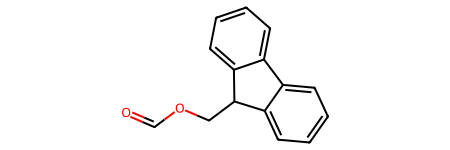

In [9]:
# Common substructures
common_substructure1 = Chem.MolFromSmiles('O=COCC1c2ccccc2-c2ccccc21') # Biphenyl core
common_substructure1

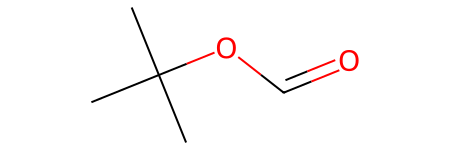

In [10]:
common_substructure2 = Chem.MolFromSmiles('CC(C)(C)OC(=O)') # Tert butyl acetate
common_substructure2

In [11]:
directory = Path("data/shrunken/")
test_BBS_dict_reverse_1 = pickle.load(open(directory / 'test_dicts/BBs_dict_reverse_1_test.p', 'br'))
test_BBS_dict_reverse_2 = pickle.load(open(directory / 'test_dicts/BBs_dict_reverse_2_test.p', 'br'))
test_BBS_dict_reverse_3 = pickle.load(open(directory / 'test_dicts/BBs_dict_reverse_3_test.p', 'br'))

In [12]:
BBs_dict_reverse_1 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_1.p', 'br'))

In [13]:
# Remove the common substructure and count the percentage of building blocks that contain it
count = 0
molecule_without_biphenyl = {}
for idx, smiles in enumerate(BBs_dict_reverse_1.values()):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule.HasSubstructMatch(common_substructure1):
        count += 1
    else:
        molecule_without_biphenyl[idx] =  molecule

percentage = count / len(BBs_dict_reverse_1) * 100
print(f"Percentage of building blocks that contain the common substructure in train: {percentage:.2f}%")

Percentage of building blocks that contain the common substructure in train: 100.00%


In [14]:
# Remove the common substructure and count the percentage of building blocks that contain it
count_test = 0
molecule_without_biphenyl_test = {}
for idx, smiles in enumerate(test_BBS_dict_reverse_1.values()):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule.HasSubstructMatch(common_substructure1):
        count_test += 1
    elif molecule.HasSubstructMatch(common_substructure2):
        count_test += 1
    else:
        molecule_without_biphenyl_test[idx] =  molecule

percentage_test = count_test / len(test_BBS_dict_reverse_1) * 100
print(f"Percentage of building blocks that contain the common substructure in test: {percentage_test:.2f}%")

Percentage of building blocks that contain the common substructure in test: 100.00%


In [15]:
# Read test data
test_data = get_test_data()

Loading test_data from disk...


In [16]:
# Remove the common substructures from all building block 1 molecules
for idx, molecule in molecule_without_biphenyl.items():
    test_data['BB_1'][idx] = Chem.MolToSmiles(molecule)

In [17]:
# Get the molecule without the common substructure
# Find first instance where building block 1 has index is key in molecule_without_biphenyl_test
test_data["buildingblock1_smiles"]
molecules_with_other_substructure = pd.DataFrame({})
for idx, smiles in enumerate(test_data["buildingblock1_smiles"]):
    if smiles in molecule_without_biphenyl_test.keys():
        # Add row to molecules_with_other_substructure
        # The row is test_data.iloc[idx]
        # Add it to a pandas dataframe
        row = test_data[idx].to_pandas()
        molecules_with_other_substructure = pd.concat([molecules_with_other_substructure, row], axis=0)

    if len(molecules_with_other_substructure) == 5:
        break

molecules_with_other_substructure.head()

""


In [18]:
test_data

buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,is_BRD4,is_HSA,is_sEH
i16,i16,i16,str,bool,bool,bool
0,17,17,"""C#CCCC[C@H](Nc…",true,true,true
0,17,87,"""C#CCCC[C@H](Nc…",true,true,true
0,17,99,"""C#CCCC[C@H](Nc…",true,true,true
0,17,244,"""C#CCCC[C@H](Nc…",true,true,true
0,17,394,"""C#CCCC[C@H](Nc…",true,true,true
…,…,…,…,…,…,…
340,1050,814,"""Cn1ncc2cc(Nc3n…",true,true,true
340,1050,877,"""[N-]=[N+]=NCCC…",true,true,true
340,1051,259,"""COC(=O)c1ccnc(…",true,true,true


In [19]:
# Find test data where buildingblock1 is 12
val12 = test_data.to_pandas()[test_data["buildingblock1_smiles"].to_pandas() == 12]

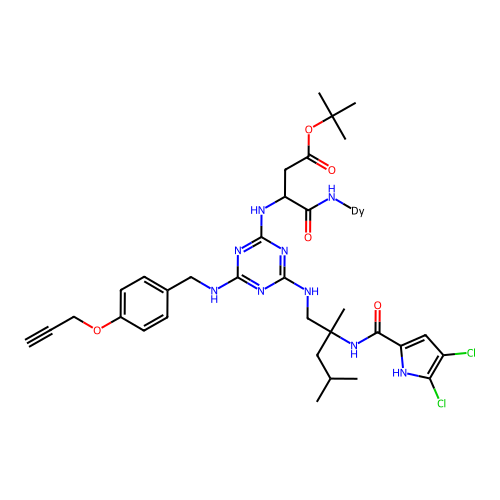

In [20]:
val12.iloc[0].molecule_smiles
# Draw the molecule
molecule = Chem.MolFromSmiles(val12.iloc[0].molecule_smiles)
display(Draw.MolToImage(molecule, size=(500, 500)))

In [21]:
val11 = test_data.to_pandas()[test_data["buildingblock1_smiles"].to_pandas() == 15]

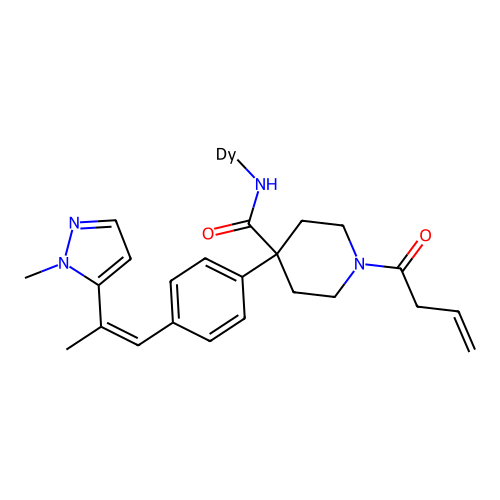

In [22]:
val11.iloc[0].molecule_smiles
molecule = Chem.MolFromSmiles(val11.iloc[0].molecule_smiles)
display(Draw.MolToImage(molecule, size=(500, 500)))

In [23]:
bb1_molecule_list = [Chem.MolFromSmiles(smiles) for smiles in test_BBS_dict_reverse_1.values()]

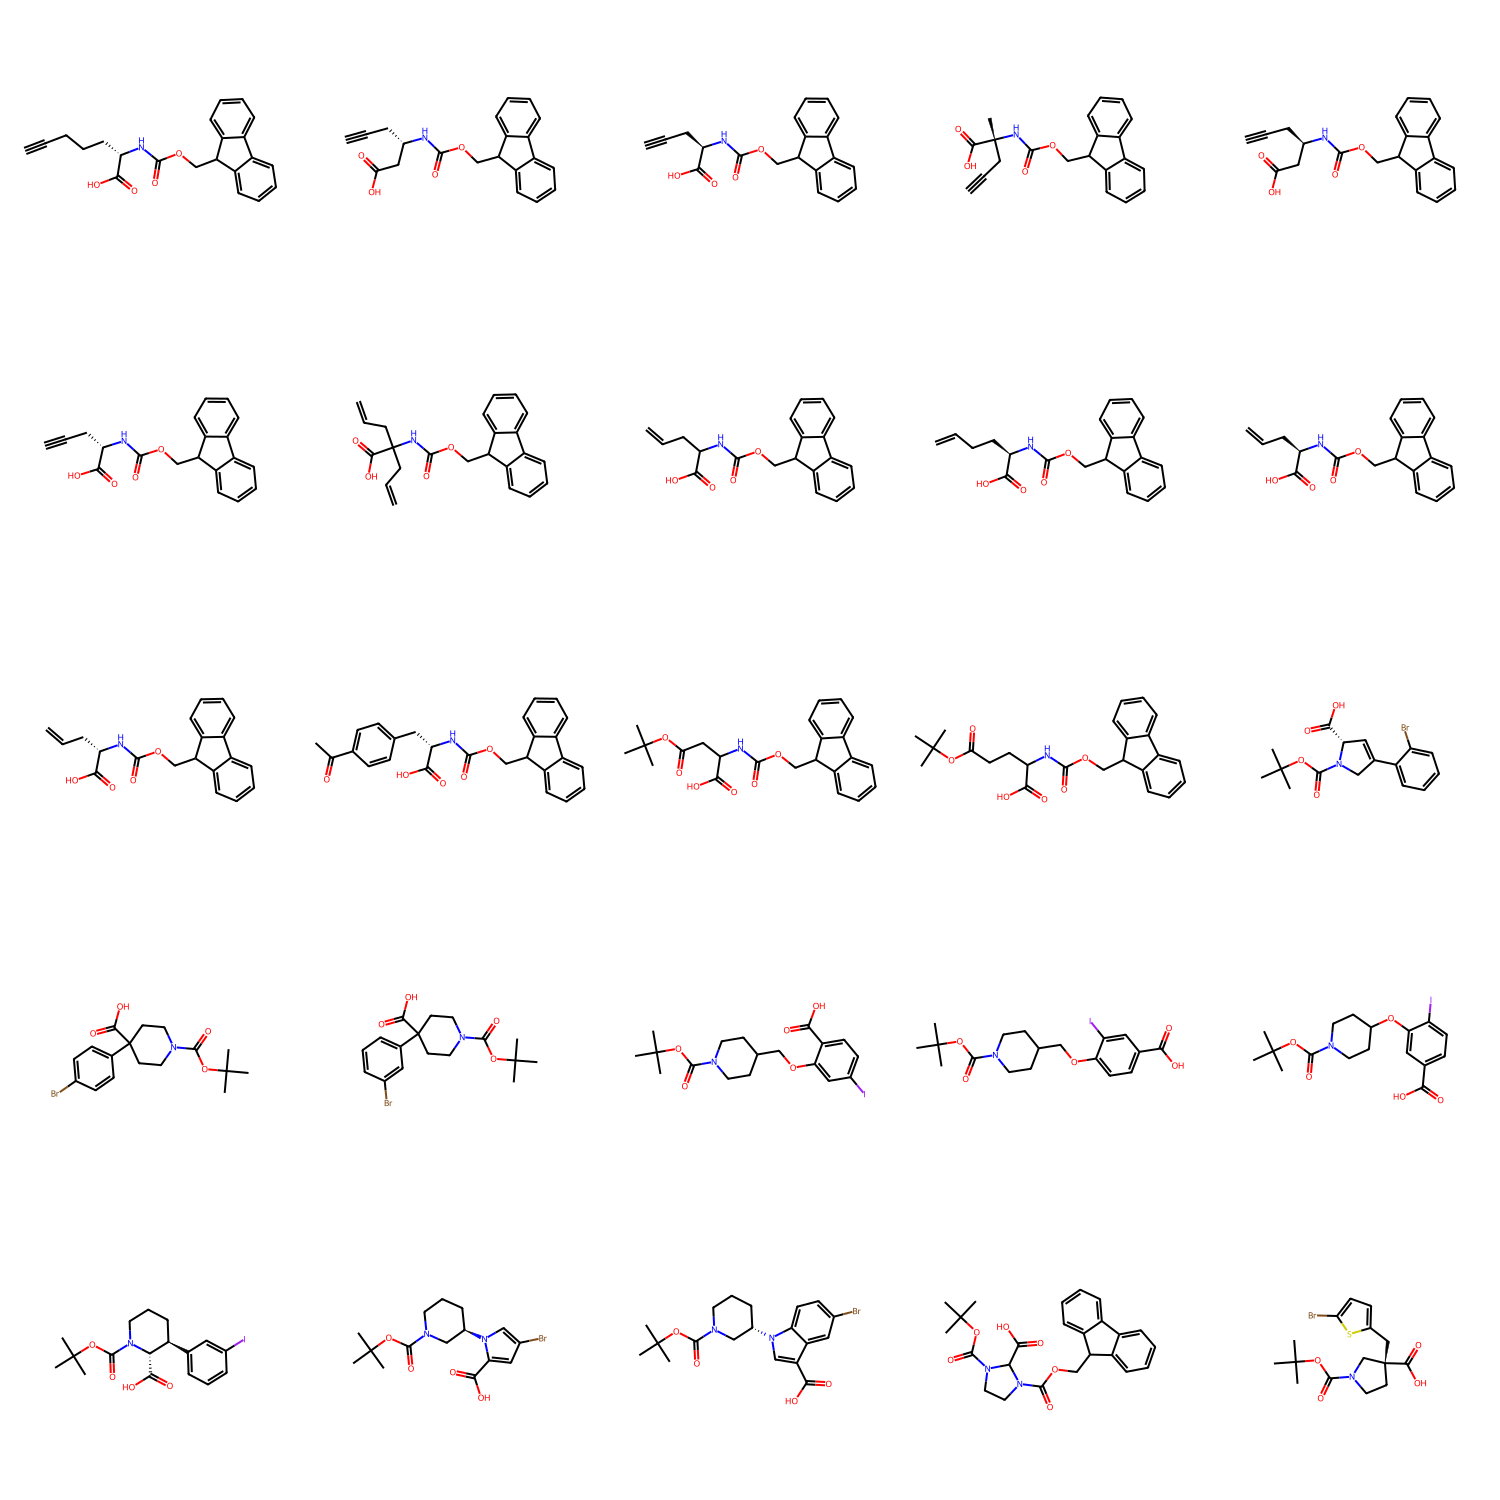

In [24]:
Draw.MolsToGridImage(bb1_molecule_list[:25], molsPerRow=5, subImgSize=(300, 300))

Modified 341 molecules, original: 341


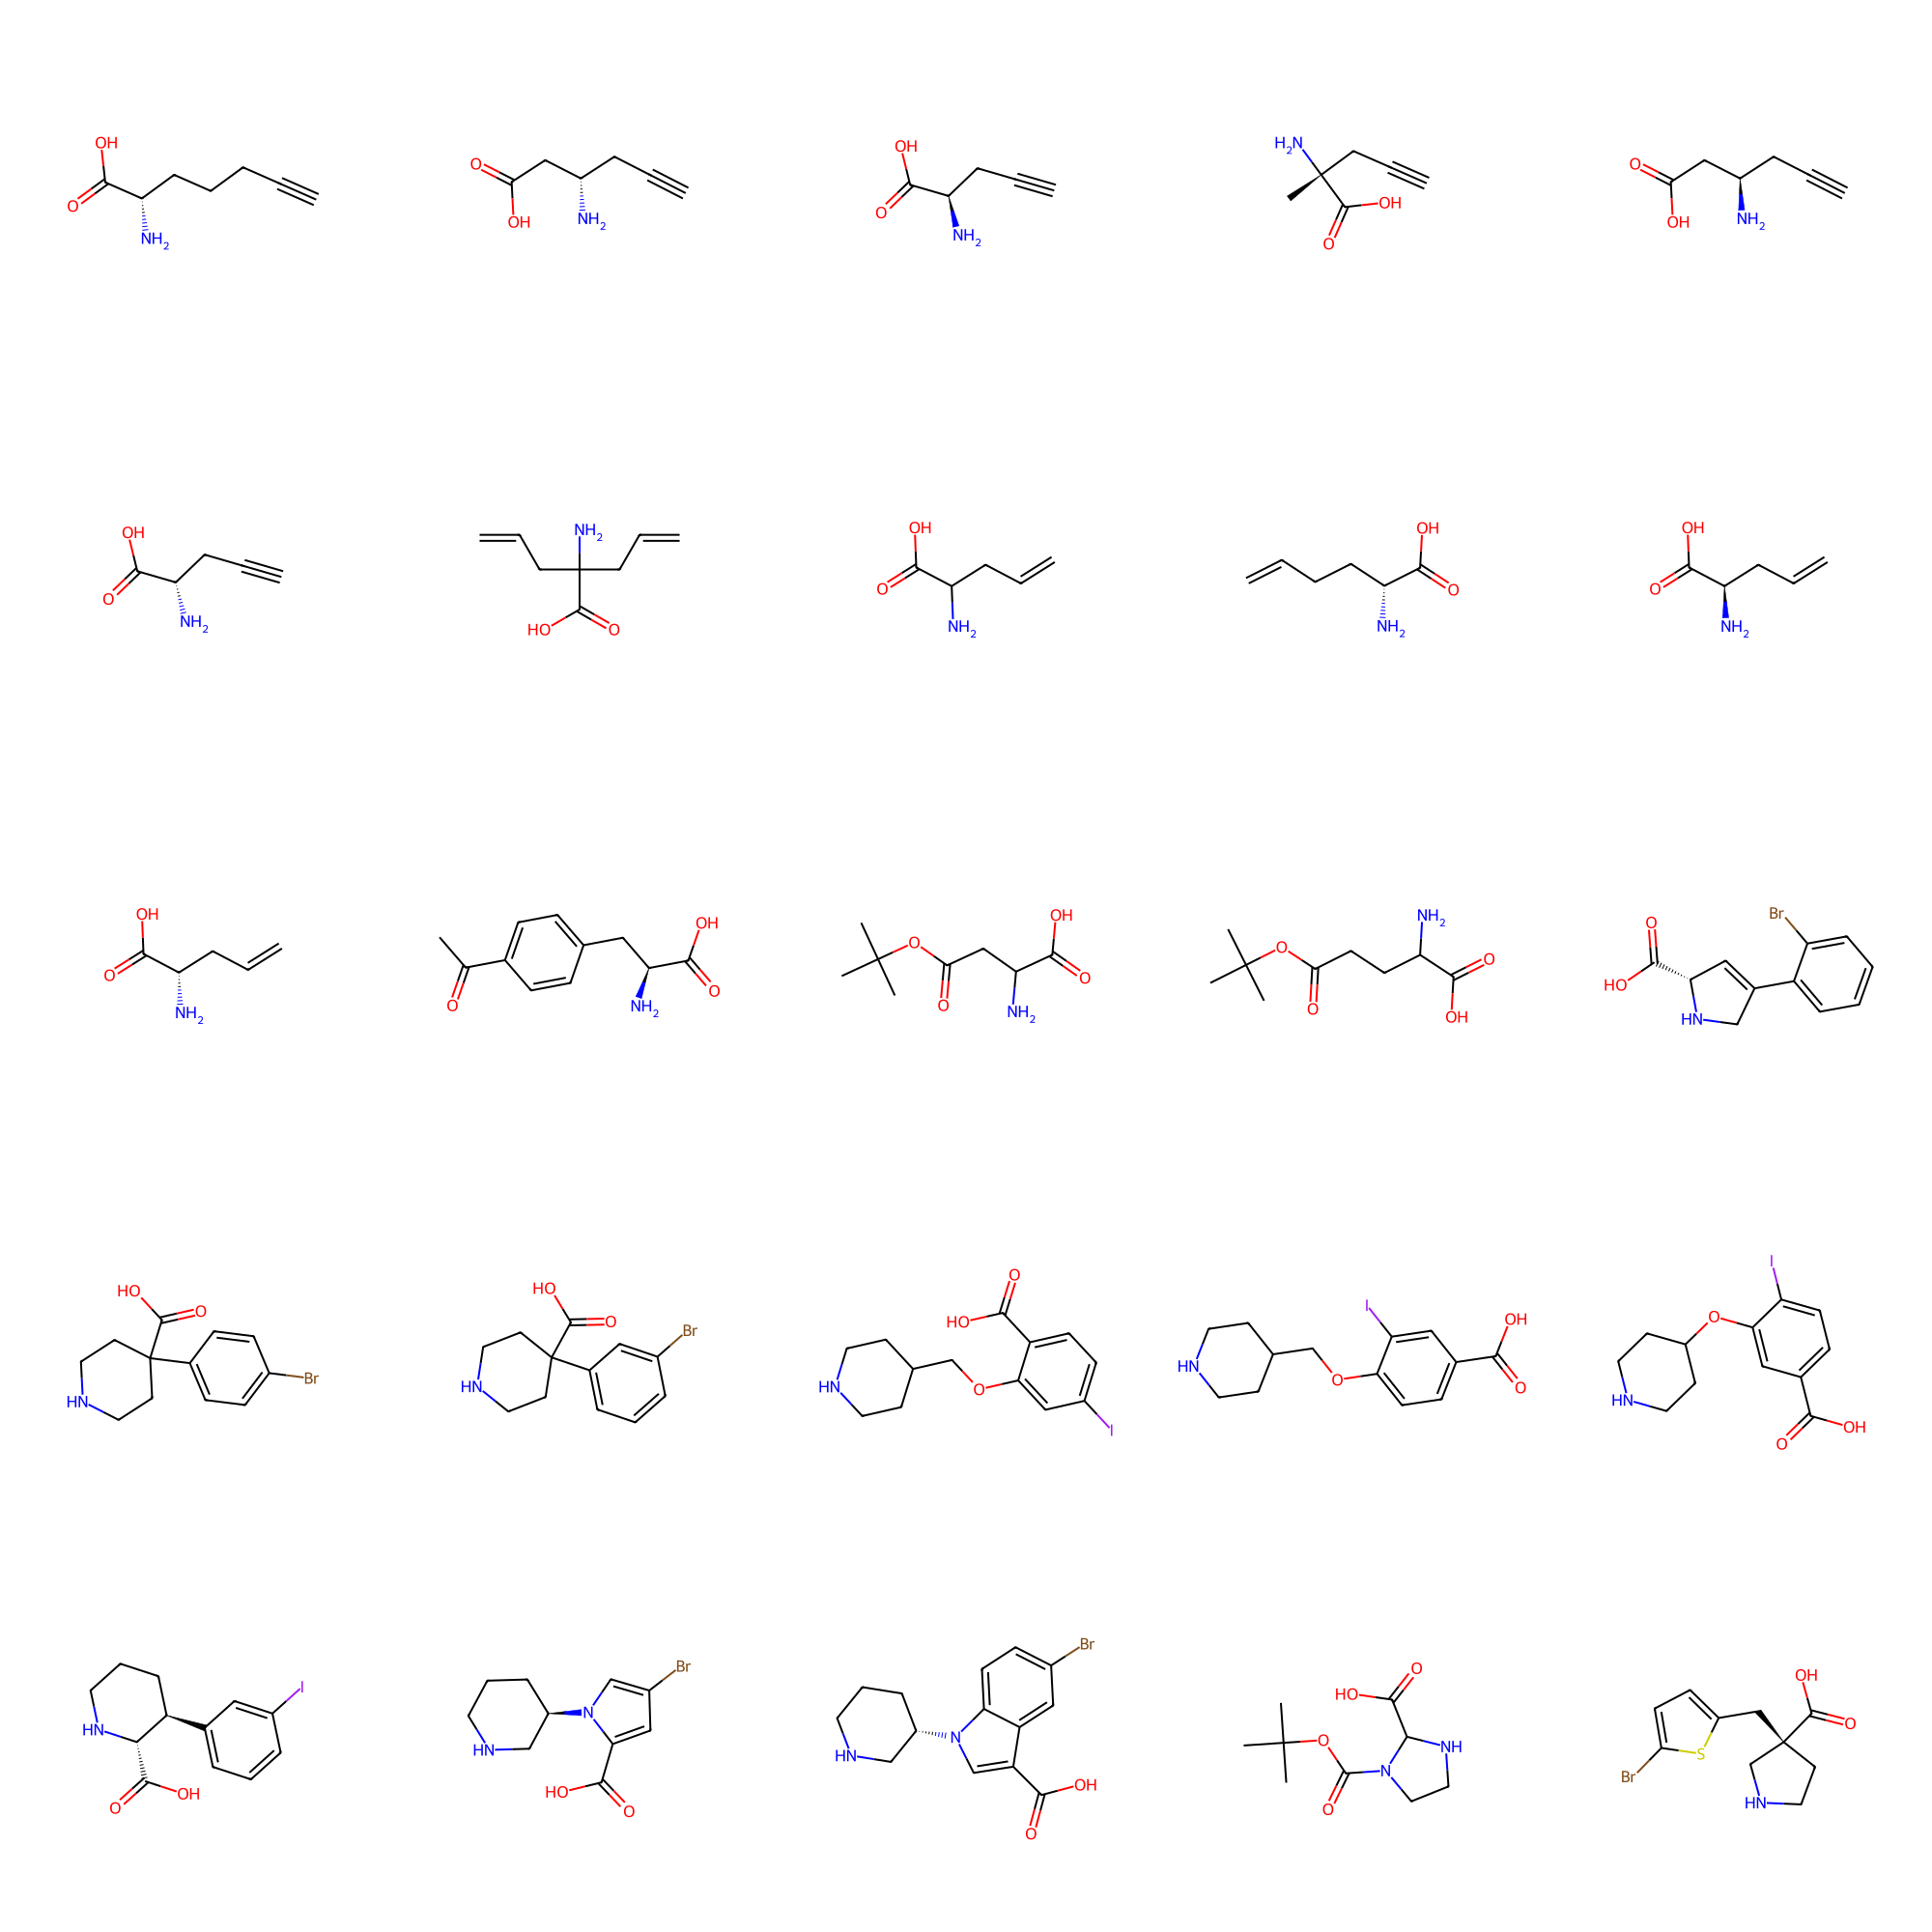

In [29]:
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in test_BBS_dict_reverse_1.values()]

# Remove the common substructure from the molecules
modified_molecule_list = []
for molecule in molecule_list:
    if molecule.HasSubstructMatch(common_substructure1):
        # Delete substructure
        modified = Chem.rdmolops.DeleteSubstructs(molecule, common_substructure1, onlyFrags=False)
        # Update the molecule
        modified_molecule_list.append(modified)
    elif molecule.HasSubstructMatch(common_substructure2):
        # Delete substructure
        modified = Chem.rdmolops.DeleteSubstructs(molecule, common_substructure2, onlyFrags=False)
        # Update the molecule
        modified_molecule_list.append(modified)

print(f"Modified {len(modified_molecule_list)} molecules, original: {len(molecule_list)}")

Draw.MolsToGridImage(modified_molecule_list[0:25], molsPerRow=5, maxMols=len(modified_molecule_list), subImgSize=(400,400))

In [26]:
# Turn modified molecules back to SMILES
modified_molecule_smiles = [Chem.MolToSmiles(molecule) for molecule in modified_molecule_list]

In [27]:
# Find the maximum length of the SMILES strings
max_len = max([len(smiles) for smiles in modified_molecule_smiles])
print(f"Maximum length of SMILES strings: {max_len}")

Maximum length of SMILES strings: 42


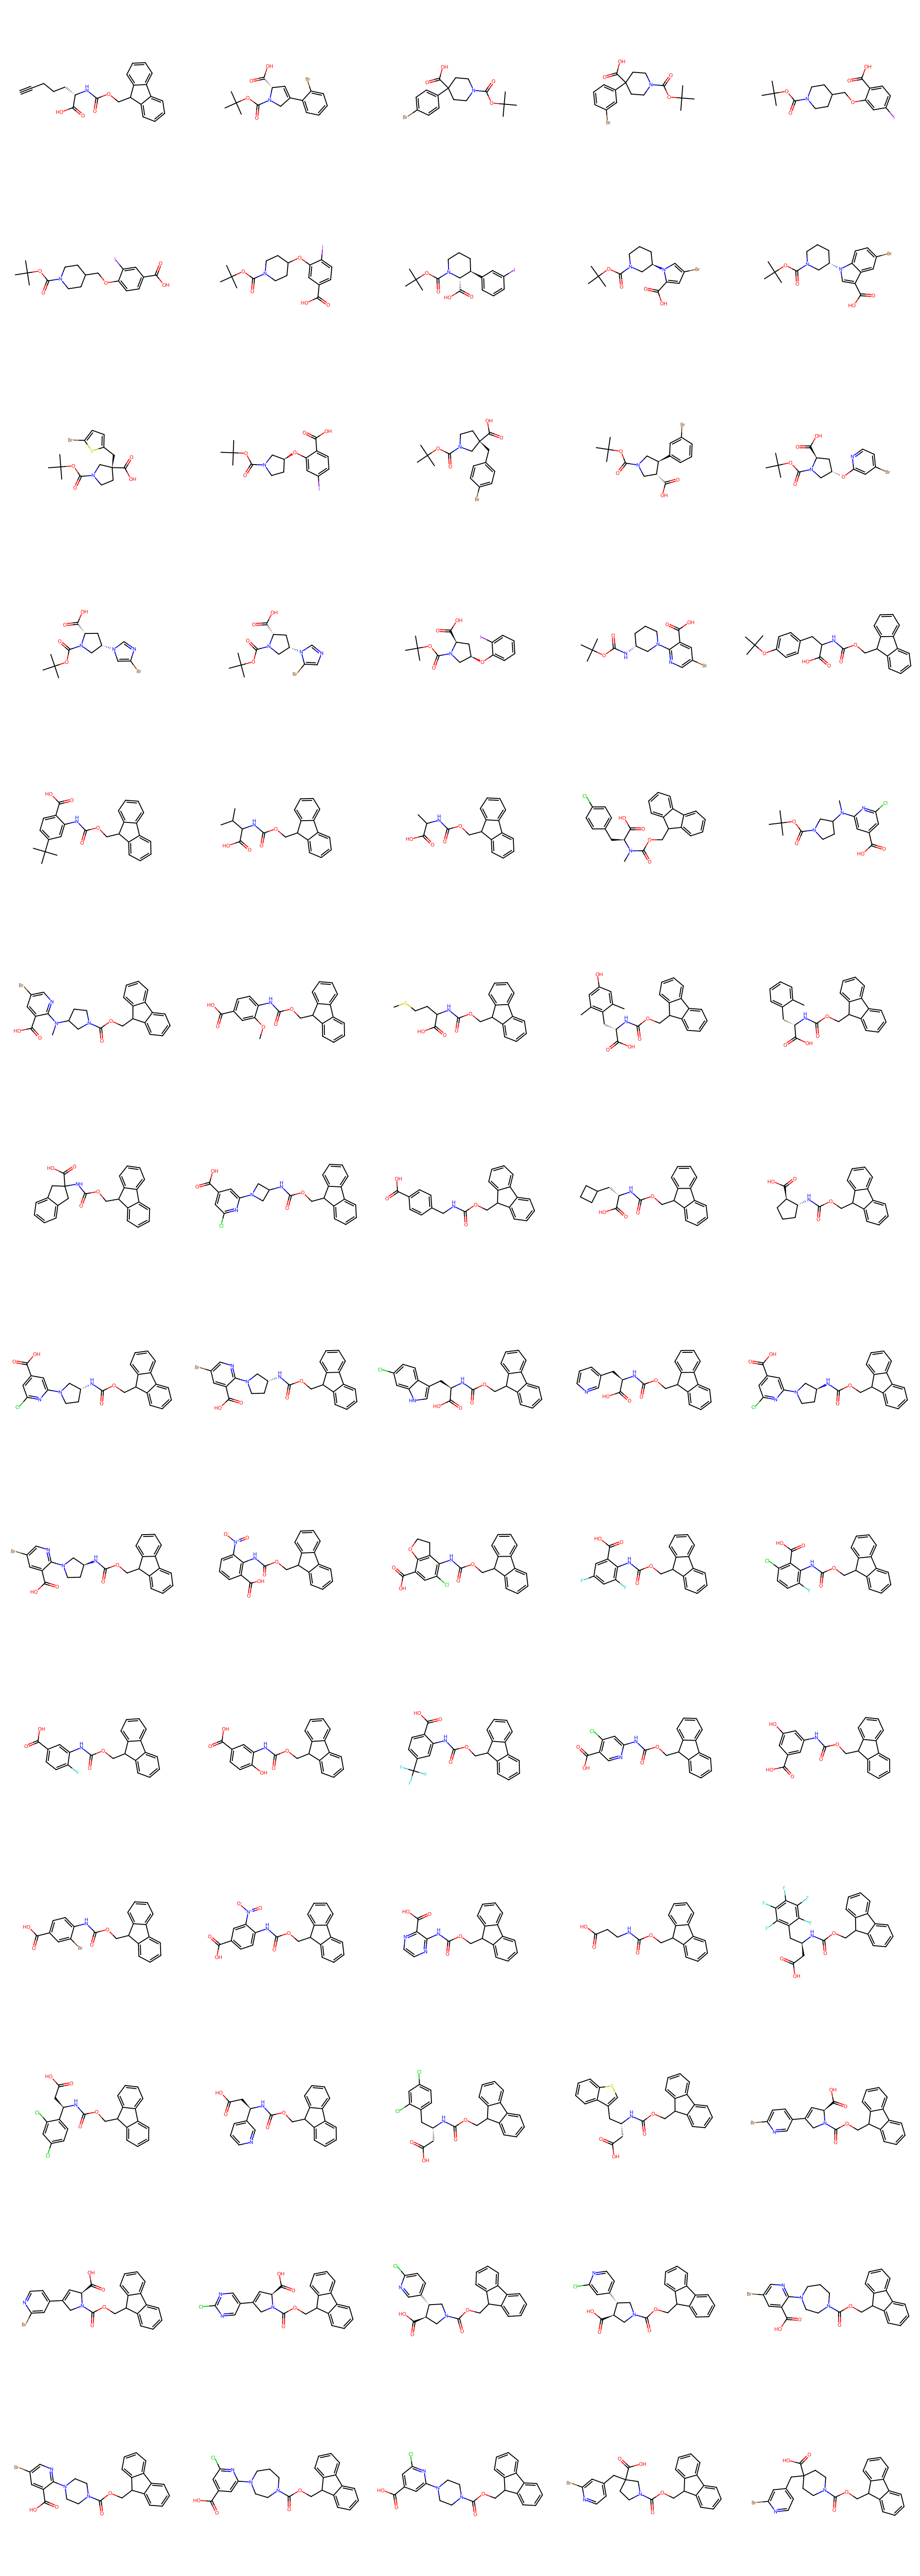

In [32]:
# Get the bb1 molecules unique to the test set
bb1_molecules_test = list(test_BBS_dict_reverse_1.values())
bb1_molecules_train = list(BBs_dict_reverse_1.values())

# Find the unique molecules in the test set
unique_molecules = [molecule for molecule in bb1_molecules_test if molecule not in bb1_molecules_train]

# SHow the unique molecules
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in unique_molecules], molsPerRow=5, maxMols=len(unique_molecules), subImgSize=(400,400))
